In [33]:
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import yaml
import scipy
from scipy.ndimage import distance_transform_edt as edt
from PIL import Image
import os
import cv2
import sys
from scipy.interpolate import splprep, splev

In [34]:
MAP_NAME = "Spielberg_map"
TRACK_WIDTH_MARGIN = 0.0 # Extra Safety margin, in meters

if os.path.exists(f"maps/{MAP_NAME}.png"):
    map_img_path = f"maps/{MAP_NAME}.png"
elif os.path.exists(f"maps/{MAP_NAME}.pgm"):
    map_img_path = f"maps/{MAP_NAME}.pgm"
else:
    raise Exception("Map not found!")

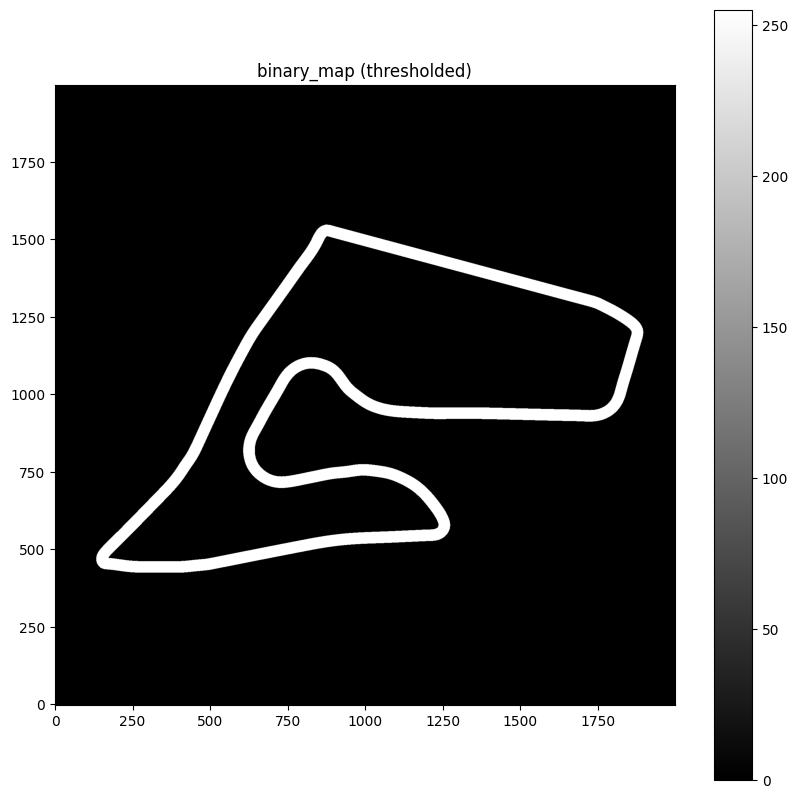

In [35]:
map_img = cv2.imread(f"maps/{MAP_NAME}.png", cv2.IMREAD_GRAYSCALE) # Load Map

# Ensure map_img is a valid numeric array
if map_img is None:
    raise FileNotFoundError(f"Map image not found at 'maps/{MAP_NAME}.png'")

_, binary_map = cv2.threshold(map_img, 250, 255, cv2.THRESH_BINARY) # Convert to Binary

# ==== Visualize ====
plt.figure(figsize=(10, 10))
plt.title("binary_map (thresholded)")
plt.imshow(binary_map, cmap='gray', origin='lower')
plt.colorbar()
plt.show()

Found 2 contours.
2420
2318


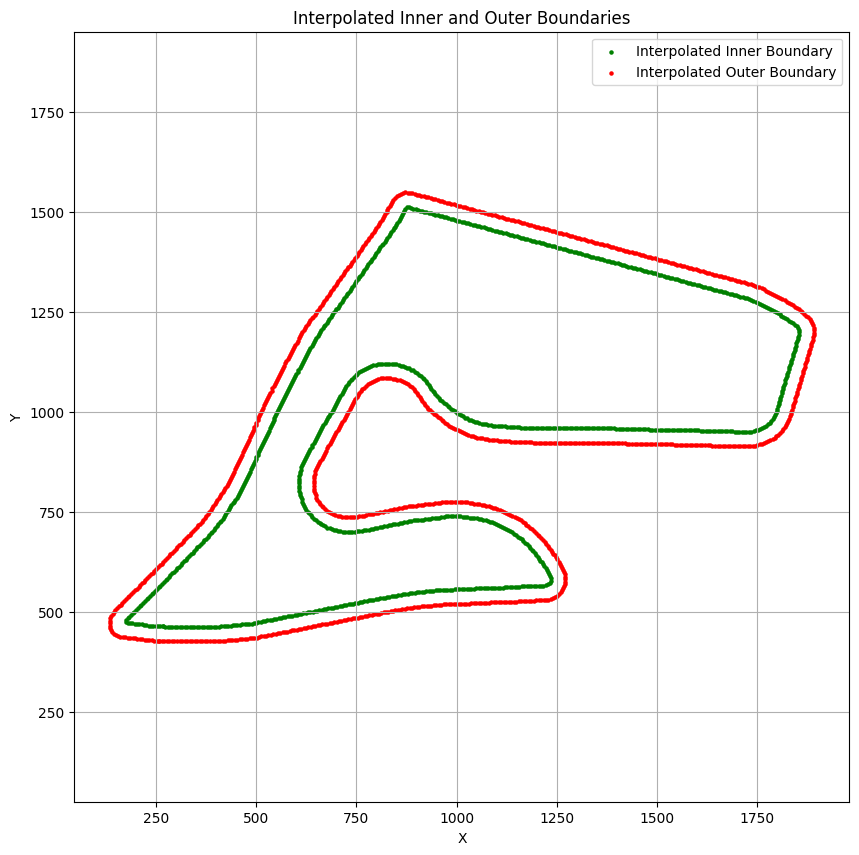

In [39]:
# ==== STEP 2: Extract Boundaries using OpenCV ====
contours, _ = cv2.findContours(binary_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Ensure we have at least two contours
if len(contours) < 2:
    raise ValueError("Not enough contours found to determine both outer and inner boundaries.")

# Sort contours by area (descending)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
outer_contour = sorted_contours[0]  # Largest contour (outer boundary)
inner_contour = sorted_contours[1]  # Second largest contour (inner boundary)

print(f"Found {len(contours)} contours.")  # Debugging: Check number of contours

# Convert contour points into a list of (x, y) waypoints
outer_boundary_waypoints = np.array(outer_contour.squeeze())  # Remove extra dimension
inner_boundary_waypoints = np.array(inner_contour.squeeze())  # Remove extra dimension

print(len(outer_boundary_waypoints))
print(len(inner_boundary_waypoints))

# Close the contours by adding the first point to the end
if len(outer_boundary_waypoints) > 0:
    outer_boundary_waypoints = np.vstack([outer_boundary_waypoints, outer_boundary_waypoints[0]])

if len(inner_boundary_waypoints) > 0:
    inner_boundary_waypoints = np.vstack([inner_boundary_waypoints, inner_boundary_waypoints[0]])

def resample_contour(contour, num_points):
    contour = contour.squeeze()
    # Calculate cumulative distance along the contour
    distances = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
    cum_dist = np.insert(np.cumsum(distances), 0, 0)
    total_dist = cum_dist[-1]
    
    # Handle edge case (stationary contour)
    if total_dist == 0:
        return np.repeat(contour[0:1], num_points, axis=0)
    
    # Linear interpolation to resample
    new_distances = np.linspace(0, total_dist, num_points)
    new_contour = np.zeros((num_points, 2))
    
    current_idx = 0
    for i in range(num_points):
        while (current_idx < len(cum_dist)-1 and 
               cum_dist[current_idx + 1] < new_distances[i]):
            current_idx += 1
        if current_idx >= len(cum_dist)-1:
            new_contour[i:] = contour[-1]
            break
        t = (new_distances[i] - cum_dist[current_idx]) / distances[current_idx]
        new_contour[i] = contour[current_idx] * (1 - t) + contour[current_idx + 1] * t
    return new_contour

# ==== Interpolate Inner and Outer Boundaries ====
num_interpolated_points = 1000  # Adjust the number of points as needed
interpolated_inner = resample_contour(inner_boundary_waypoints, num_interpolated_points)
interpolated_outer = resample_contour(outer_boundary_waypoints, num_interpolated_points)

# ==== Visualize the Interpolated Boundaries ====
plt.figure(figsize=(10, 10))
plt.title("Interpolated Inner and Outer Boundaries")
plt.scatter(interpolated_inner[:, 0], interpolated_inner[:, 1], c='g', s=5, label="Interpolated Inner Boundary")
plt.scatter(interpolated_outer[:, 0], interpolated_outer[:, 1], c='r', s=5, label="Interpolated Outer Boundary")
plt.legend()
plt.axis("equal")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


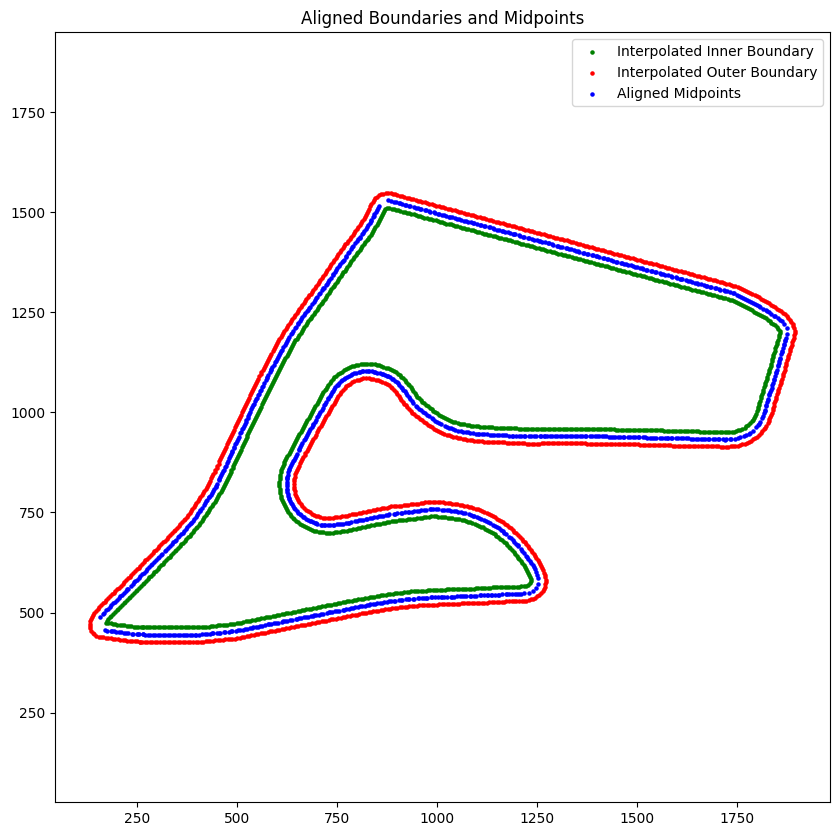

In [44]:
# Arrays to store aligned points
aligned_inner = []
aligned_outer = []
aligned_midpoints = []

# Iterate through each point in the inner boundary
for inner_point in interpolated_inner:
    # Calculate distances to all outer boundary points
    distances = np.linalg.norm(interpolated_outer - inner_point, axis=1)
    
    # Find the index of the closest outer boundary point
    closest_idx = np.argmin(distances)
    
    # Get the corresponding outer boundary point
    outer_point = interpolated_outer[closest_idx]
    
    # Compute the midpoint
    midpoint = (inner_point + outer_point) / 2
    
    # Append to aligned arrays
    aligned_inner.append(inner_point)
    aligned_outer.append(outer_point)
    aligned_midpoints.append(midpoint)

# Convert aligned lists to NumPy arrays
aligned_inner = np.array(aligned_inner)
aligned_outer = np.array(aligned_outer)
aligned_midpoints = np.array(aligned_midpoints)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.title("Aligned Boundaries and Midpoints")
plt.scatter(interpolated_inner[:, 0], interpolated_inner[:, 1], c='g', s=5, label="Interpolated Inner Boundary")
plt.scatter(interpolated_outer[:, 0], interpolated_outer[:, 1], c='r', s=5, label="Interpolated Outer Boundary")
plt.scatter(aligned_midpoints[:, 0], aligned_midpoints[:, 1], c='b', s=5, label="Aligned Midpoints")  # Small blue dots
plt.legend()
plt.axis("equal")
plt.show()